# Setup

In [1]:
# Standard library imports
import warnings
import os
from random import gauss

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from pandas.plotting import autocorrelation_plot

from pmdarima.arima import auto_arima
from pmdarima import pipeline, model_selection, arima
from pmdarima import preprocessing as ppc

# Configuration & Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

This collection of lines imports various modules necessary for time series analysis and data manipulation. 

The first section brings in modules from Python’s standard library: `warnings` to manage warning messages, `os` for interacting with the operating system (like file paths), and `random.gauss` for generating normally distributed random numbers.

Next, several third-party libraries are imported. `pandas` is used for data manipulation and analysis, particularly with DataFrames. `numpy` provides support for numerical operations, especially arrays. Again, `random.gauss` appears – it’s likely included twice by mistake. `matplotlib.pyplot` enables the creation of plots and visualizations. `statsmodels.api` offers a wide range of statistical models, including time series analysis tools. Specific functions from `statsmodels`, like those for plotting autocorrelation and partial autocorrelation (from `tsaplots`), fitting autoregressive models (`ar_model`), decomposing seasonality (`seasonal`), and performing stationarity tests (`adfuller`) are also imported.  `ArmaProcess` is used to generate data from an ARMA model, and `autocorrelation_plot` provides a convenient way to visualize autocorrelation.

Finally, the code imports modules from the `pmdarima` library, which specializes in ARIMA modeling. This includes functions for automatic ARIMA order selection (`auto_arima`), building pipelines of transformations and models (`pipeline`), splitting data for model evaluation (`model_selection`), working with ARIMA models directly (`arima`), and preprocessing time series data (`preprocessing`).

The last line suppresses `FutureWarning` messages, which can clutter the output without necessarily indicating a critical problem. This is done to keep the console cleaner during execution.

In [2]:
# general settings
class CFG:
    data_folder = './data/'
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42


# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)

np.random.seed(CFG.SEED)

This code establishes general settings and visual preferences for a project involving data analysis and plotting. 

A class named `CFG` is defined to hold configuration variables. It specifies the location of the data folder as `./data/`, sets image dimensions to 20x10 (for visualizations), and defines a random seed value of 42 for reproducibility.

Following this, the code adjusts the plotting style using Matplotlib.  It applies the "seaborn-v0_8" style theme and configures the default figure size based on the `img_dim1` and `img_dim2` values defined in the `CFG` class – setting the standard width and height of plots to 20x10 inches.

Lastly, it sets the seed for NumPy’s random number generator using the value stored in `CFG.SEED`. This ensures that any randomized operations within the code will produce consistent results each time the program is run, aiding in debugging and reproducibility.

# Utils

In [3]:
def plot_acf_pacf(
    series,
    lags=20,
    title=None
):

    fig, axes = plt.subplots(2, 1, sharex=True)

    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation (ACF)")

    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation (PACF)")

    if title:
        fig.suptitle(title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        fig.tight_layout()

    plt.show()


This function generates and displays plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series. 

The function begins by creating a figure with two subplots arranged vertically, sharing the same x-axis. It then uses functions from the `statsmodels` library (`plot_acf` and `plot_pacf`) to generate the ACF plot on the top subplot and the PACF plot on the bottom subplot. Each subplot receives a descriptive title: "Autocorrelation (ACF)" and "Partial Autocorrelation (PACF)", respectively.

An optional `title` argument allows for an overarching title to be added to the entire figure using `fig.suptitle`. If a title is provided, the layout of the subplots is adjusted with `fig.tight_layout` to ensure the main title doesn’t overlap with the plots themselves.  If no title is given, a standard tight layout is applied.

Finally, `plt.show()` displays the generated figure containing both ACF and PACF plots. The `lags` parameter controls how many lags are displayed on each plot; its default value is 20. These plots are useful for identifying patterns of correlation within the time series data, which can inform choices about appropriate statistical models (like ARIMA) to use for forecasting or analysis.

In [4]:
def print_adf_result(data, name="Series"):
    # Handle NaN values automatically for differenced data
    data = data.dropna()
    result = adfuller(data)
    print(f'\n--- ADF Test: {name} ---')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

This function performs the Augmented Dickey-Fuller (ADF) test on a given time series and prints the results in a formatted way. The ADF test is used to determine if a time series is stationary, which is an important property for many time series models.

The function takes two arguments: `data`, which is the time series data to be tested, and `name`, which is an optional string providing a descriptive name for the series being analyzed (defaults to "Series"). 

First, `data = data.dropna()` removes any missing values (NaNs) from the input data. This is important because the ADF test cannot handle missing values.

Then, `result = adfuller(data)` performs the ADF test using the `adfuller` function from the `statsmodels` library. The result object contains various statistics related to the test. 

The code then prints a header indicating which series is being tested and proceeds to print key results: the ADF statistic, the p-value, and critical values at different significance levels (1%, 5%, and 10%).  The ADF statistic and p-value are formatted to six decimal places for readability. The critical values are printed with three decimal places.

By examining the p-value in relation to the chosen significance level, you can determine whether to reject or fail to reject the null hypothesis that the time series has a unit root (i.e., is non-stationary). If the p-value is less than the significance level, you reject the null hypothesis and conclude that the series is likely stationary.

# Linear processes

## AR processes

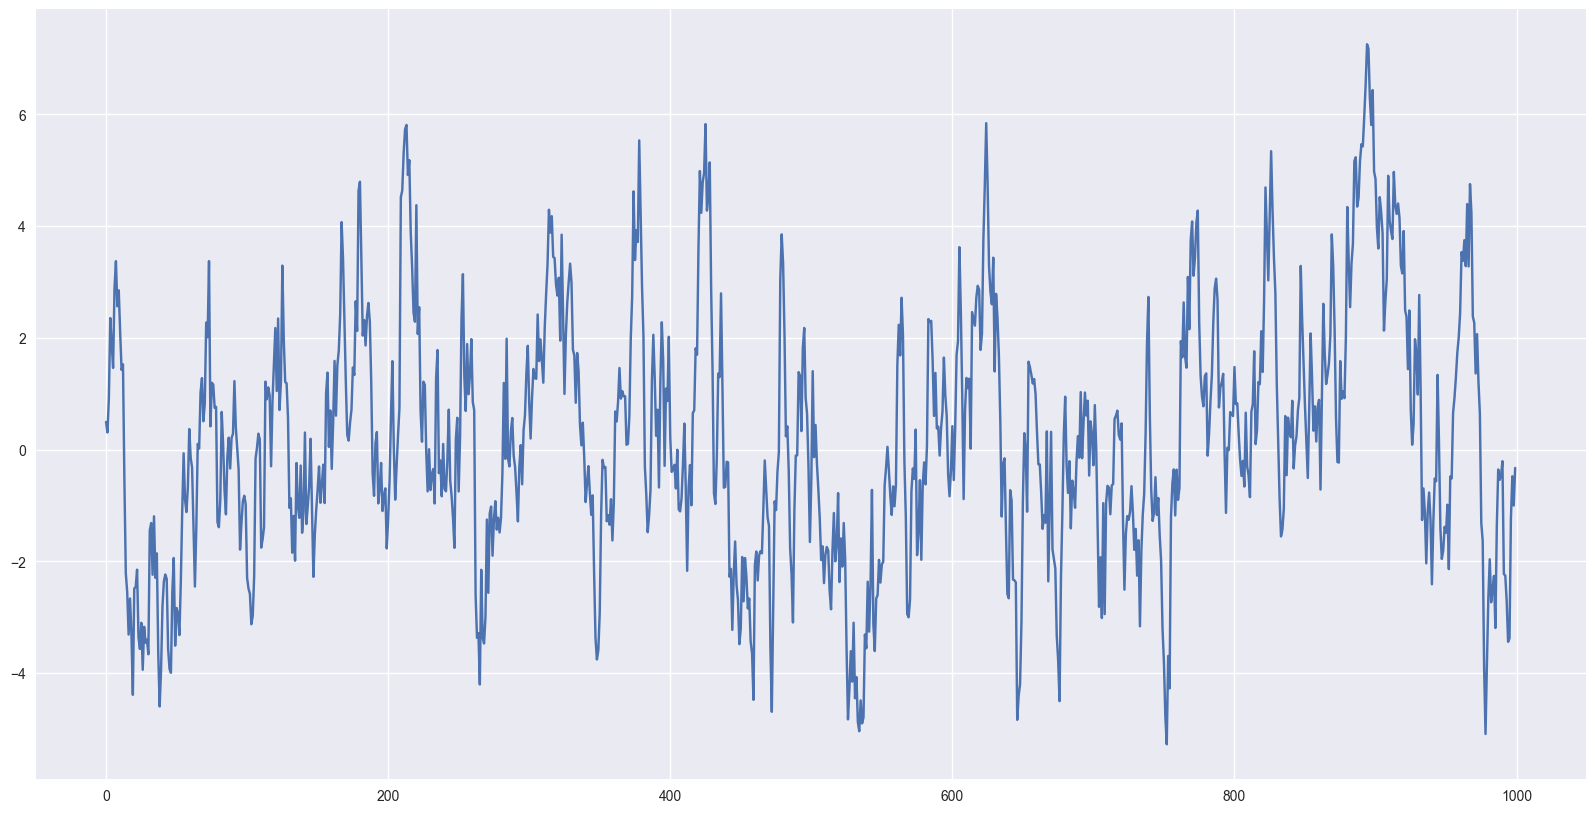

In [5]:
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

This code simulates data from an autoregressive (AR) process and then visualizes the generated time series.

First, `ar1 = np.array([1, -0.9])` defines the coefficients for an AR(1) model. An AR(1) model means that the current value in the series is a linear combination of its immediately preceding value plus a constant term (which is implicitly 1 due to how the coefficients are used). In this case, the current value is equal to 1 times the previous value minus 0.9 times the previous value.

Next, `ma1 = np.array([1])` defines the coefficients for a moving average (MA) component of order 0. Since only one element exists in the array, it indicates there's no MA component; this effectively makes the model purely autoregressive.

The line `AR_object1 = ArmaProcess(ar1, ma1)` creates an object representing the ARMA process using the specified coefficients from the `statsmodels` library. 

Then, `simulated_data_1 = AR_object1.generate_sample(nsample=1000)` generates a time series of length 1000 samples based on the defined ARMA model. This simulates data that would be produced by this process if it were operating in reality.

Finally, `plt.plot(simulated_data_1)` plots the generated time series and `plt.show()` displays the plot, allowing you to visually inspect the simulated data. The resulting graph will show a fluctuating line representing the values of the time series over the 1000 samples. Because of the negative autocorrelation coefficient (-0.9), the series will exhibit some degree of persistence or correlation between consecutive values.

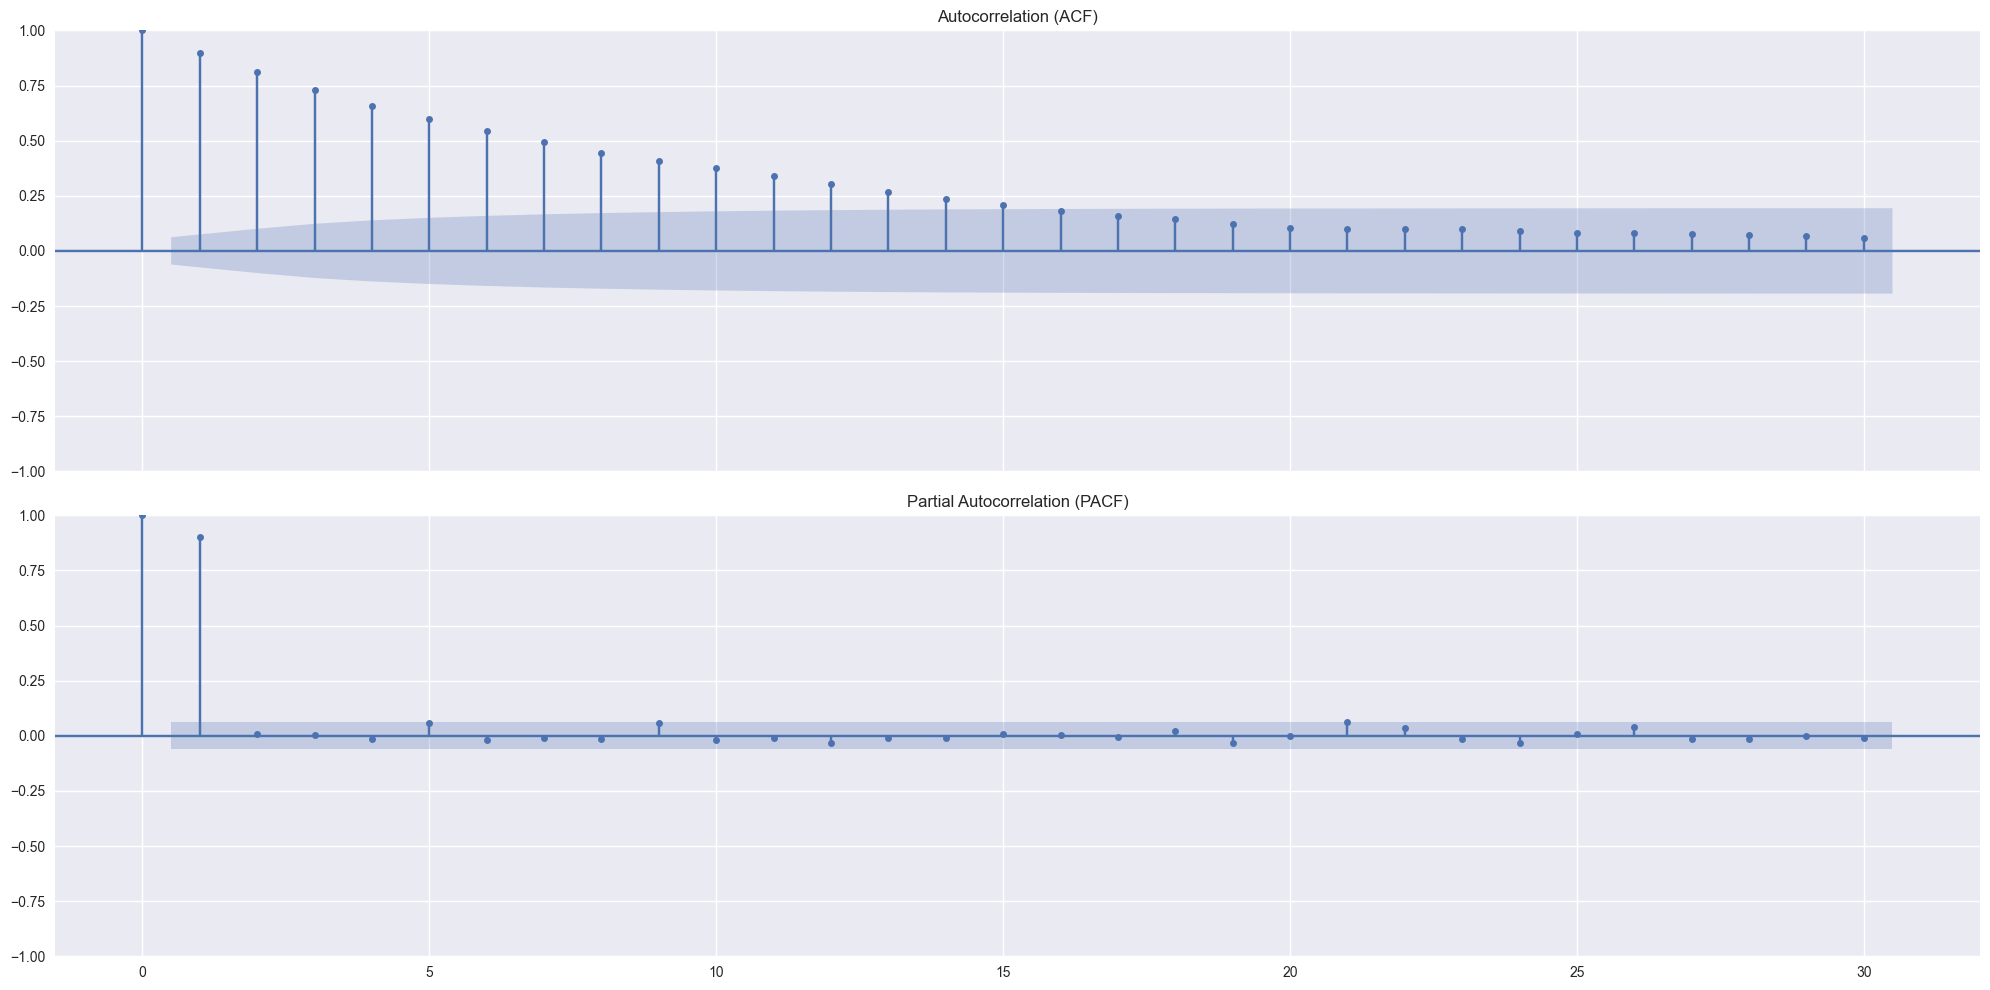

In [6]:
plot_acf_pacf(simulated_data_1, lags=30)

## MA processes

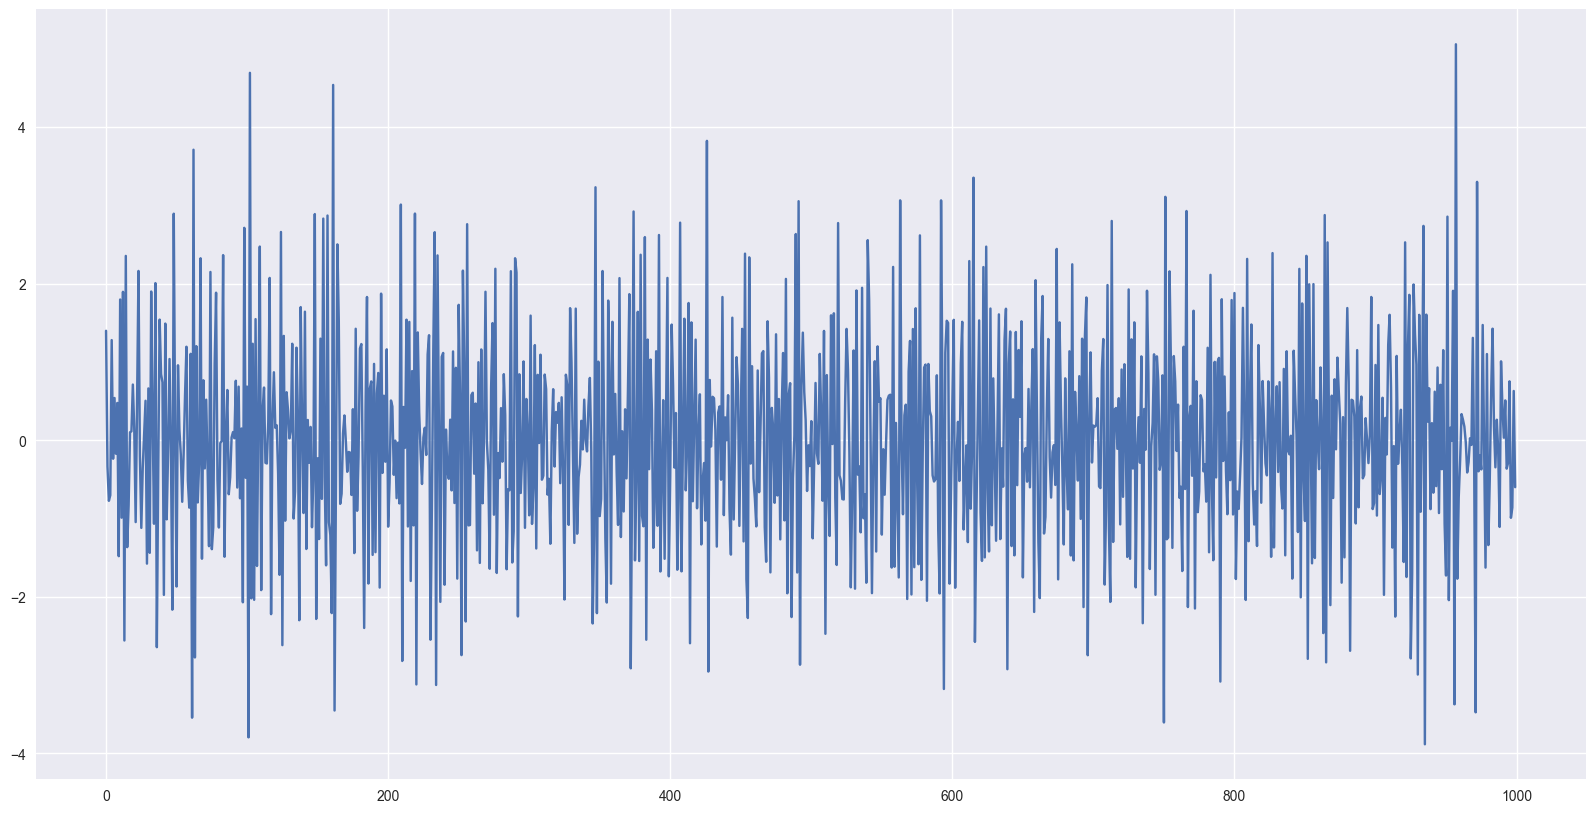

In [7]:
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_2 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

This code simulates data from a moving average (MA) process and then displays the resulting time series as a plot.

The line `ar1 = np.array([1])` defines the autoregressive component of an ARMA model. Setting it to `[1]` indicates that there is no autoregressive part; the current value does not depend on past values of the series directly. 

Then, `ma1 = np.array([1, -0.9])` specifies the coefficients for a moving average (MA) component of order 1. An MA(1) model means that the current value is a linear combination of the current and one previous random shock (error term). In this case, the current value is equal to the current shock plus (-0.9) times the previous shock.

`MA_object1 = ArmaProcess(ar1, ma1)` creates an object representing the ARMA process using these coefficients from the `statsmodels` library. 

The line `simulated_data_2 = MA_object1.generate_sample(nsample=1000)` generates a time series of length 1000 samples based on this MA model, simulating data that would be produced by such a process.

Finally, `plt.plot(simulated_data_2)` plots the generated time series and `plt.show()` displays the plot. The resulting graph will show a fluctuating line representing the values of the time series over 1000 samples. Because of the MA component, the series will exhibit short-term correlations; a positive shock today will be followed by a negative shock tomorrow with some probability due to the -0.9 coefficient.

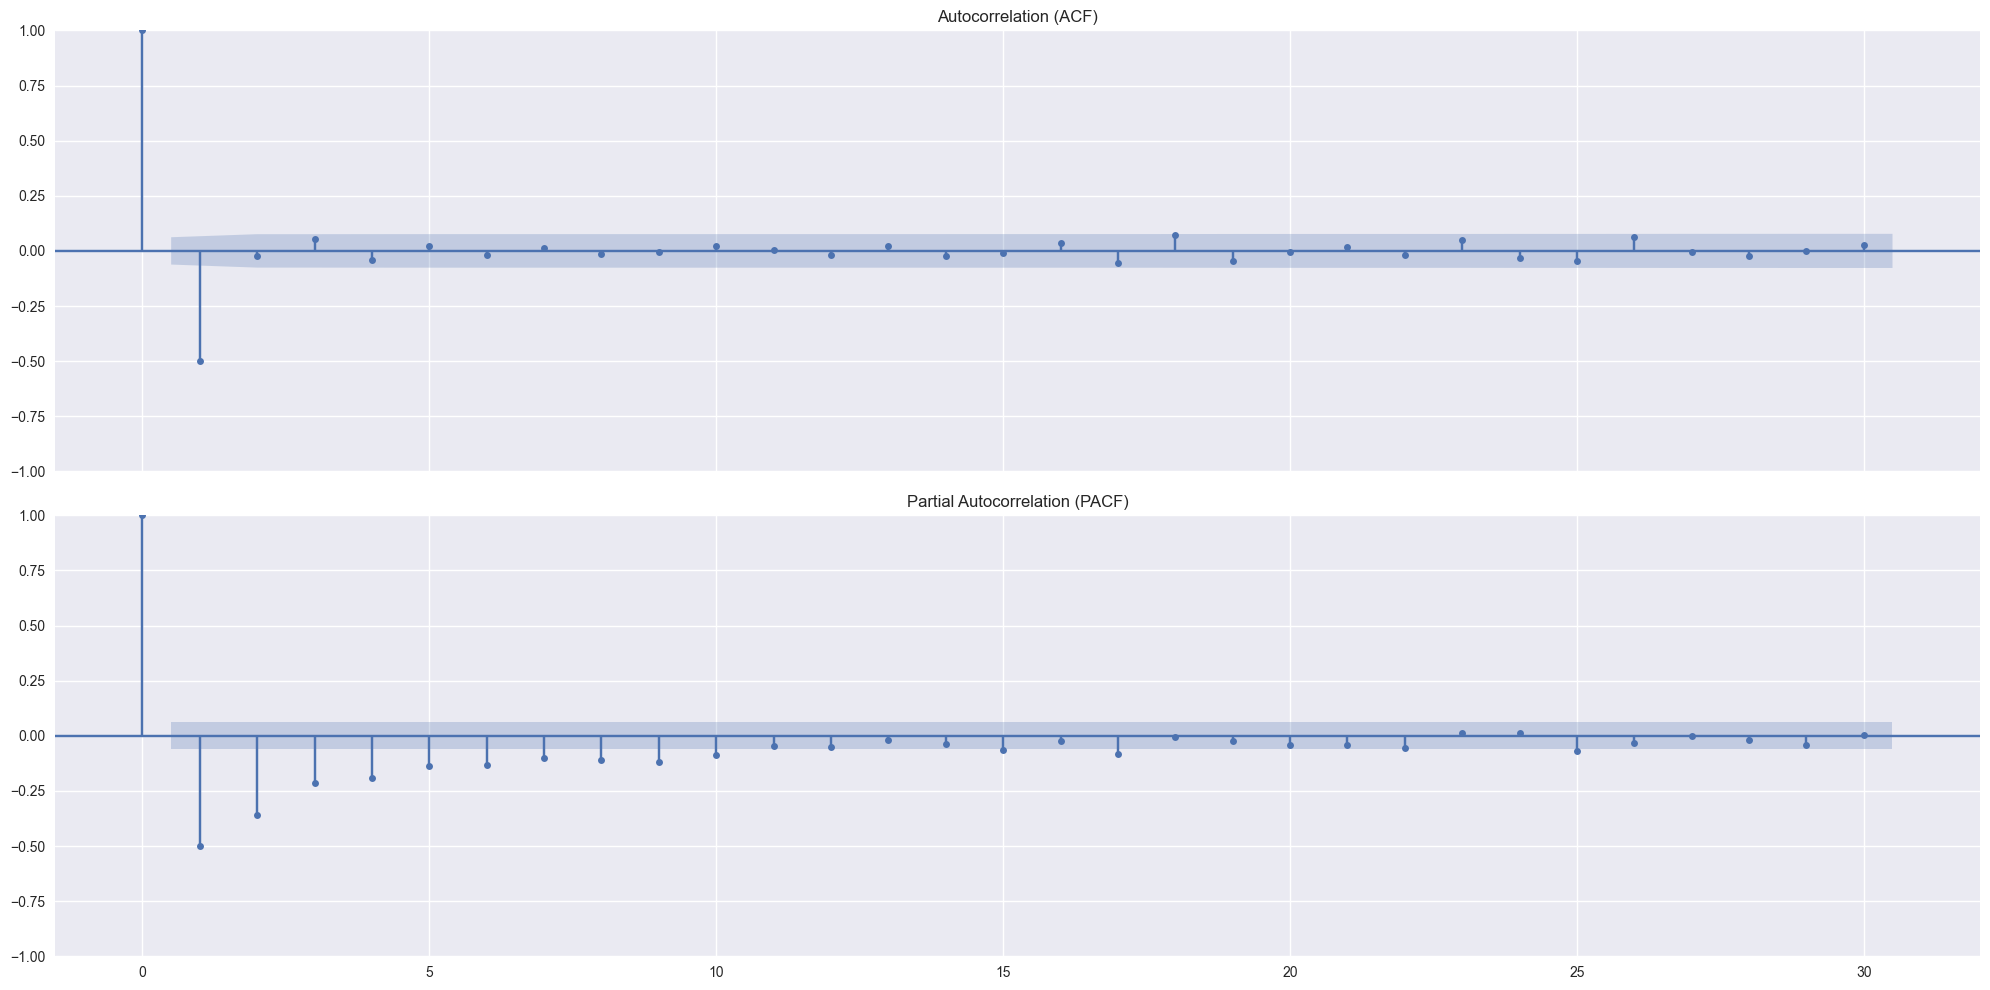

In [8]:
plot_acf_pacf(simulated_data_2, lags=30)

## ARMA

<Axes: xlabel='date'>

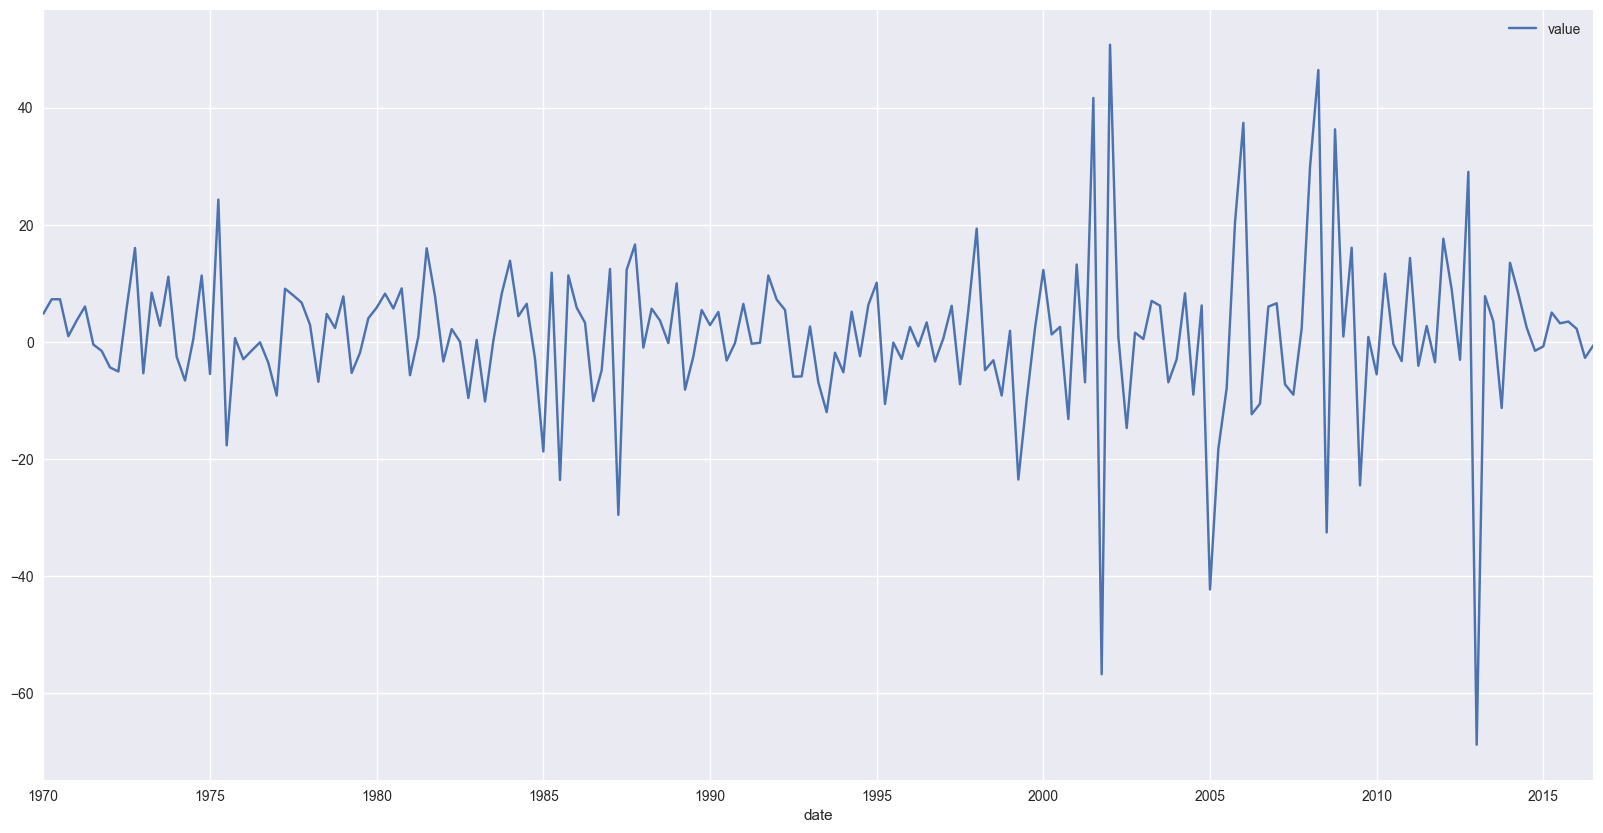

In [9]:
xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')

xdat.columns = ['date', 'value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot()

This code reads time series data from a CSV file, prepares it for analysis, and then generates a line plot of the data over time. 

First, `xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')` reads the data from a CSV file named "savings_change.csv". The location of this file is determined by combining the value of `CFG.data_folder` (which is assumed to be a pre-defined path) with the filename. This data is stored in a Pandas DataFrame called `xdat`.

Next, `xdat.columns = ['date', 'value']` assigns column names "date" and "value" to the columns of the DataFrame. It’s assuming that the CSV file either doesn't have headers or has headers that should be replaced with these names. 

The line `xdat['date'] = pd.to_datetime(xdat['date'])` converts the 'date' column from its original data type (likely strings) to a datetime format, which is essential for time series analysis and plotting. This allows Pandas to correctly interpret dates and times.

Finally, `xdat.set_index('date').plot()` sets the 'date' column as the index of the DataFrame and then generates a line plot using the default plotting functionality of Pandas. The x-axis of the plot will represent the dates, and the y-axis will represent the corresponding values from the 'value' column. This visualization allows for easy inspection of how the savings change data evolves over time.

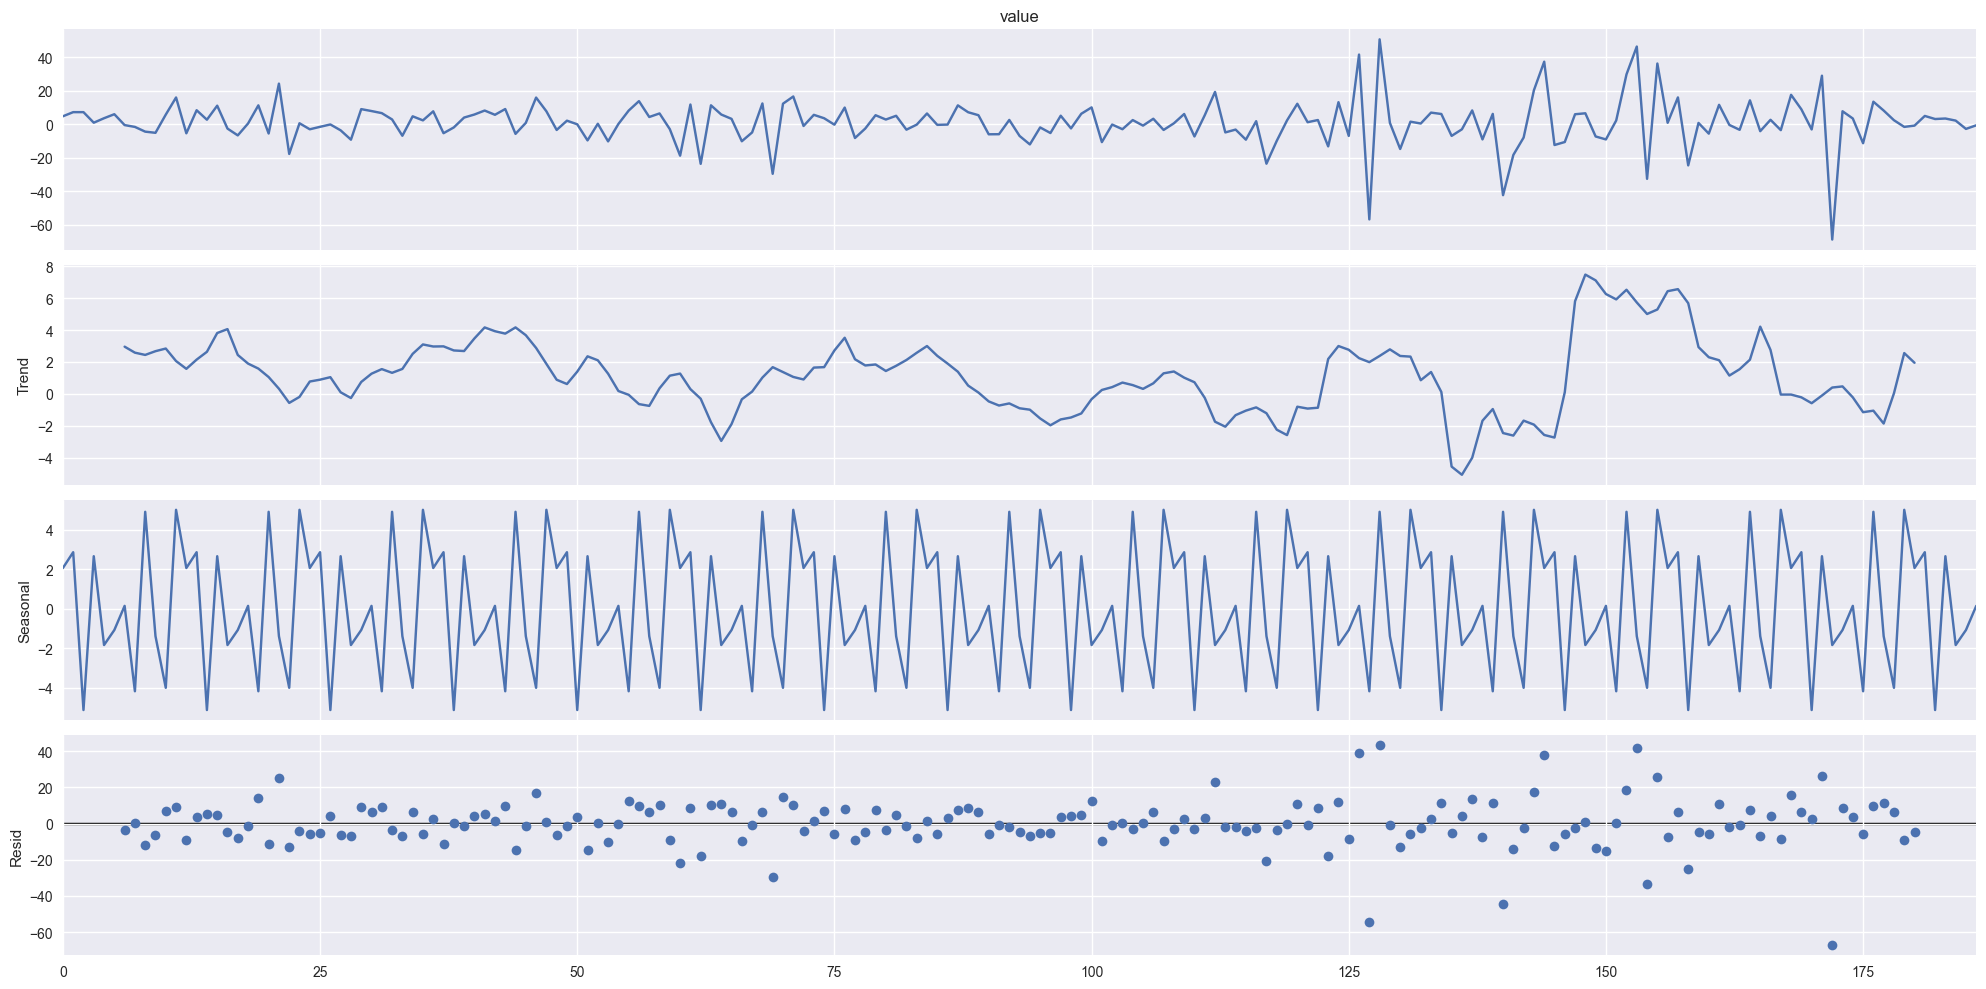

In [10]:
decomposition = seasonal_decompose(xdat["value"],period =12, model = 'additive') 
figure = decomposition.plot()
plt.show()

This code performs a seasonal decomposition of a time series and then visualizes the results.

`decomposition = seasonal_decompose(xdat["value"], period=12, model='additive')` applies a seasonal decomposition to the 'value' column of the `xdat` DataFrame using the `seasonal_decompose` function from the `statsmodels` library. The `period=12` argument specifies that the seasonality is assumed to be yearly (12 months). The `model='additive'` argument indicates that the time series is modeled as a sum of its trend, seasonal, and residual components:  Value = Trend + Seasonality + Residual.

The line `figure = decomposition.plot()` generates a plot showing the decomposed components – the original time series, the estimated trend component, the estimated seasonal component, and the residuals (the remaining variation not explained by the trend or seasonality). The function returns a Matplotlib figure object containing these subplots. 

Finally, `plt.show()` displays the generated plot, allowing you to visually inspect each of the decomposed components and understand the underlying patterns in the time series data. This is useful for identifying trends, seasonal fluctuations, and any remaining irregular variations within the savings change data.

In [11]:
print_adf_result(xdat['value'])


--- ADF Test: Series ---
ADF Statistic: -18.705760
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


This line of code executes the `print_adf_result` function with the 'value' column from the `xdat` DataFrame as input. 

Specifically, it passes the time series data contained in `xdat['value']` to the function. This will perform an Augmented Dickey-Fuller (ADF) test on this time series and print the results – including the ADF statistic, p-value, and critical values – to the console. The output will help determine whether the 'value' column of your data is stationary or not. Because no `name` argument is provided, the function will label the analysis as being performed on "Series".

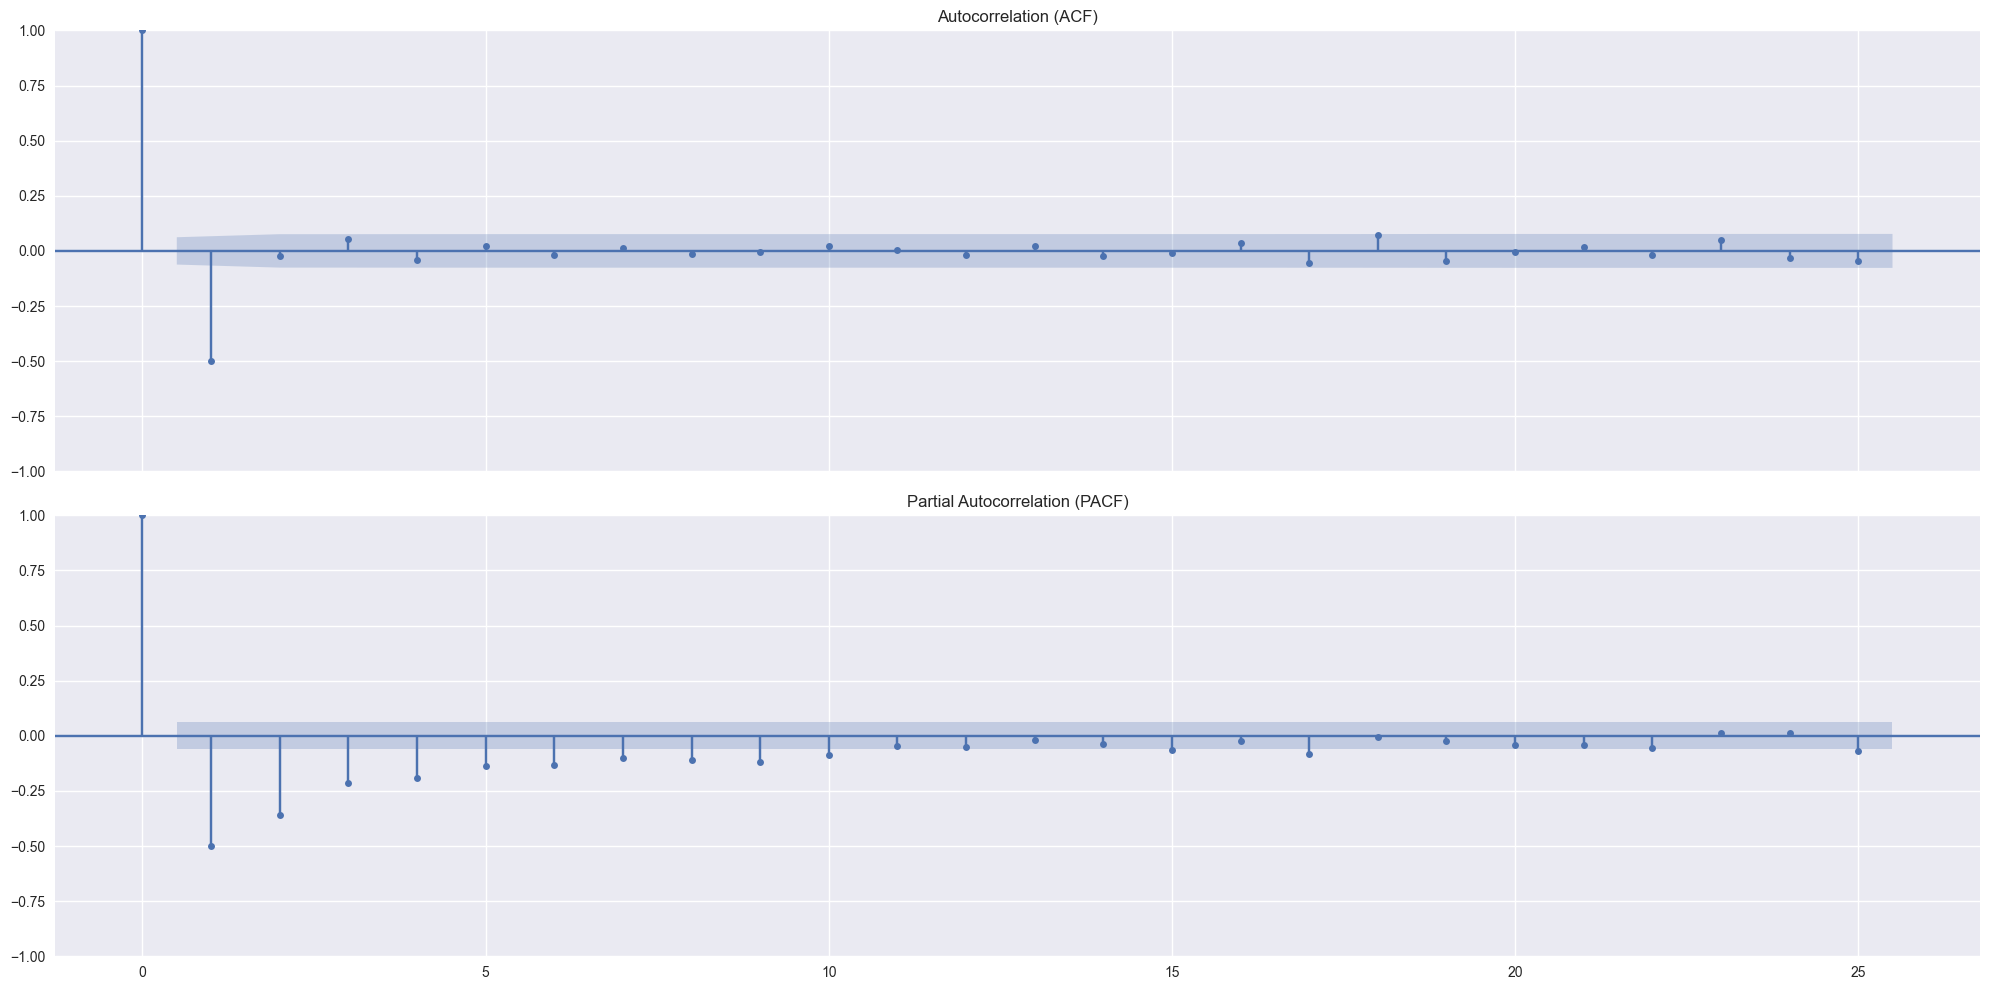

In [12]:
plot_acf_pacf(simulated_data_2, lags=25)

In [13]:

xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 12)



`xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size=12)` uses the `train_test_split` function from the `sklearn.model_selection` module to perform this split. 

The first argument, `xdat['value']`, is the time series data that will be divided. The `test_size=12` argument specifies that the validation set (`xvalid`) should contain the last 12 observations from the time series. Consequently, the remaining observations are assigned to the training set (`xtrain`).

This approach ensures that the model is trained on historical data and then evaluated on more recent data it hasn't seen before, simulating a real-world forecasting scenario where you’re predicting future values based on past patterns. The holdout period of 12 months allows for assessing how well the model generalizes to unseen data from the same time frame as the seasonality identified earlier (period=12).

In [14]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.262 seconds


,steps,"[('fourier', ...), ('arima', ...)]"


This code constructs and fits a machine learning pipeline for time series forecasting using the AutoARIMA model with Fourier features. 

First, `pipe = pipeline.Pipeline([...])` creates a scikit-learn Pipeline object. Pipelines allow you to chain together multiple data processing steps and a final estimator (the model) into a single workflow.

Inside the Pipeline, two steps are defined:
1. `"fourier", ppc.FourierFeaturizer(m=4)`: This step uses `FourierFeaturizer`. It transforms the time series data by adding Fourier features (sine and cosine waves) with frequencies up to `m=4`. These features can help capture seasonal patterns in the data.
2. `"arima", arima.AutoARIMA(...)`: This step uses the `AutoARIMA` model from the `pmdarima` library.  The parameters configure the AutoARIMA process:
    - `stepwise=True`: Uses a stepwise search to find the optimal ARIMA order.
    - `trace=1`: Prints information about the search process (verbosity level).
    - `error_action="ignore"`: Ignores errors during model fitting, which can happen if certain parameter combinations lead to invalid models.
    - `seasonal=False`:  Specifies that no seasonal component should be considered in the ARIMA model. This is likely because seasonality has already been addressed by the Fourier features.
    - `suppress_warnings=True`: Suppresses warnings generated during the AutoARIMA process.

Finally, `pipe.fit(xtrain)` trains the pipeline on the training data (`xtrain`).  This involves first applying the Fourier feature transformation to the training data and then using the transformed data to fit the AutoARIMA model by finding its optimal parameters. The fitted pipeline is now ready for making predictions.

In [15]:
# we can inspect the results
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Sun, 18 Jan 2026   AIC                           1413.240
Time:                        21:44:43   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)

# combine the data
results_df = pd.DataFrame({ 'actual': xvalid.values,
    'predicted': preds,  'lower CI': conf_int[:, 0],  'upper CI': conf_int[:, 1] })

This code generates forecasts using a trained pipeline and organizes the results into a Pandas DataFrame for analysis.

First, `preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)` uses the fitted pipeline (`pipe`) to predict future values. The `n_periods` argument is set to the length of the validation dataset (`xvalid.shape[0]`), meaning it generates predictions for each point in the holdout period.  The `return_conf_int=True` flag ensures that confidence intervals are also calculated alongside the forecasts.

Next, `results_df = pd.DataFrame({...})` creates a Pandas DataFrame to store and organize the results. The dictionary passed to `pd.DataFrame()` defines the columns of this new table:
- `'actual': xvalid.values`: This column contains the true values from the validation set (`xvalid`).  `.values` converts the Pandas Series into a NumPy array.
- `'predicted': preds`: This column holds the forecasts generated by the pipeline.
- `'lower CI': conf_int[:, 0]`: This column stores the lower bounds of the confidence intervals for each prediction. `conf_int[:, 0]` selects all rows and the first column from the `conf_int` array, which represents these lower bounds.
- `'upper CI': conf_int[:, 1]`:  This column contains the upper bounds of the confidence intervals. `conf_int[:, 1]` extracts the second column from the `conf_int` array, representing the upper bounds.

The resulting DataFrame, `results_df`, provides a clear and structured way to compare predicted values with actual values and assess the uncertainty associated with those predictions through the confidence intervals. This is ideal for evaluating model performance and visualizing forecast accuracy.

In [37]:
results_df

,actual,predicted,lower CI,upper CI
175,-11.276615,1.404690,-24.424053,27.233433
176,13.520202,2.588137,-24.472635,29.648909
177,8.244048,1.783539,-25.394578,28.961656
178,2.461953,-2.484031,-29.673583,24.705520
179,-1.513050,3.296285,-23.894383,30.486953
180,-0.758400,1.973680,-25.217097,29.164457
181,5.023918,1.998851,-25.191937,29.189639
182,3.180930,-2.574599,-29.765388,24.616190
183,3.482786,3.347867,-23.842922,30.538656
184,2.236534,1.934282,-25.256507,29.125072


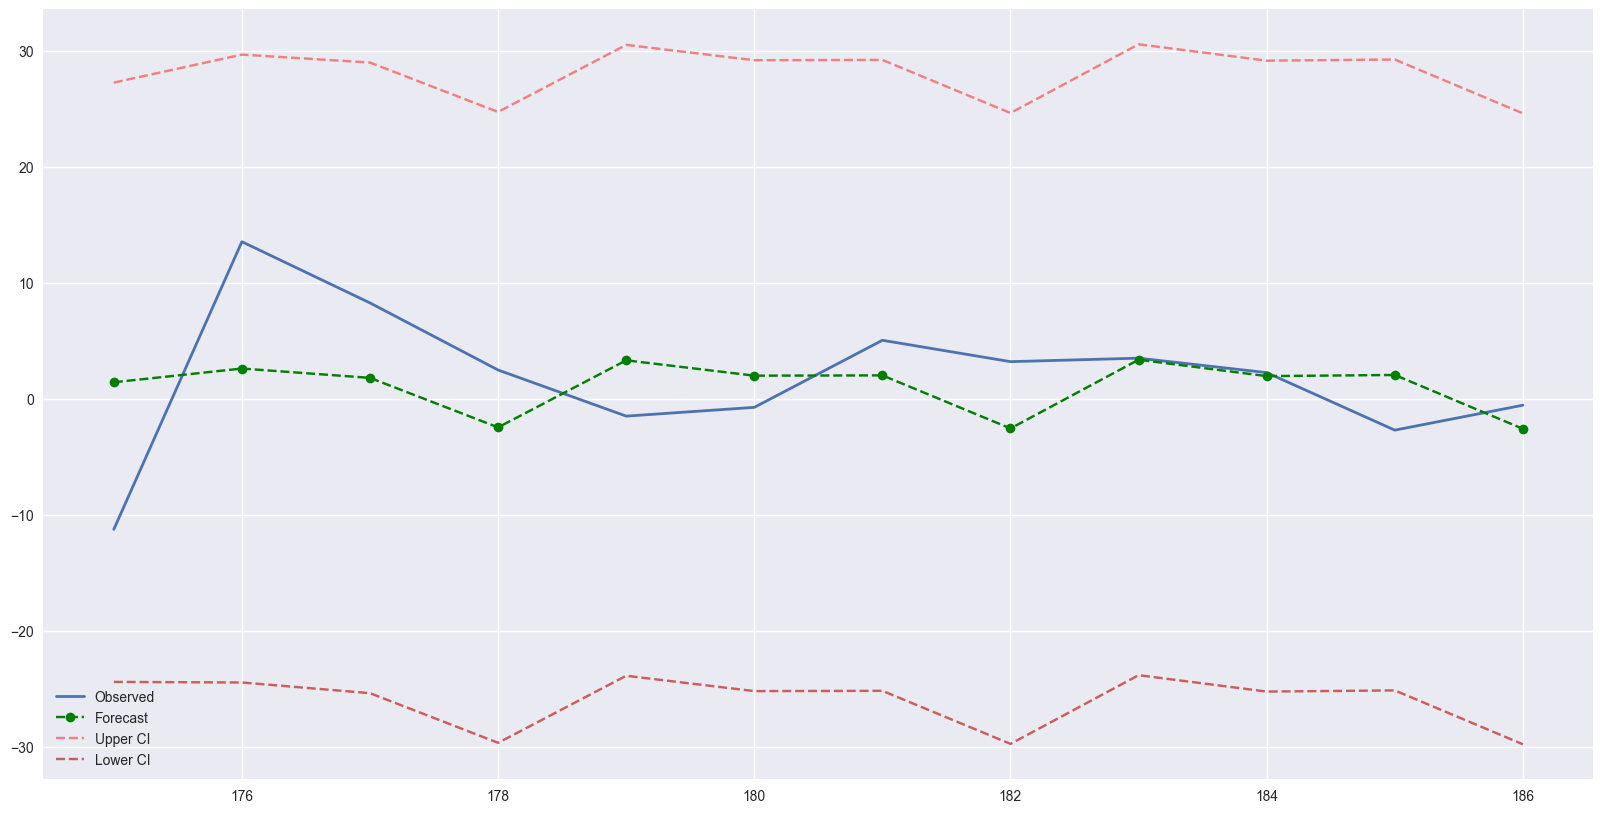

In [43]:
plt.figure()

# Original series
results_df["actual"].plot( label="Observed", linewidth=2, )
# Forecast
results_df["predicted"].plot( label="Forecast", marker="o", linestyle="--", color="green" )
# CI
results_df["upper CI"].plot( label="Upper CI", linestyle="--", color="lightcoral" )
results_df["lower CI"].plot( label="Lower CI", linestyle="--", color="indianred" )
plt.legend()
plt.show()

This code generates a plot visualizing the observed data, the forecasts generated by the model, and the confidence intervals around those forecasts.

`plt.figure()` creates a new figure for the plot. 

The following lines use the `plot` method of Pandas Series to add different components to the same plot:
- `results_df["actual"].plot( label="Observed", linewidth=2, )`: Plots the actual values from the validation set as a solid line with a width of 2 pixels. It's labeled "Observed" in the legend.
- `results_df["predicted"].plot( label="Forecast", marker="o", linestyle="--", color="green" )`: Plots the predicted values as a dashed line with circular markers, colored green.  It’s labeled “Forecast” in the legend.
- `results_df["upper CI"].plot( label="Upper CI", linestyle="--", color="lightcoral" )`: Plots the upper bound of the confidence interval as a dashed line, colored light coral. It's labeled "Upper CI" in the legend.
- `results_df["lower CI"].plot( label="Lower CI", linestyle="--", color="indianred" )`: Plots the lower bound of the confidence interval as a dashed line, colored indian red.  It’s labeled “Lower CI” in the legend.

`plt.legend()` adds a legend to the plot, which identifies each line based on its label. 

Finally, `plt.show()` displays the generated plot, allowing you to visually assess how well the forecasts align with the observed data and the range of uncertainty represented by the confidence intervals. This visualization is crucial for evaluating the model's performance and understanding the reliability of its predictions.

# Beyond ARMA

## ARIMA

<Axes: xlabel='date'>

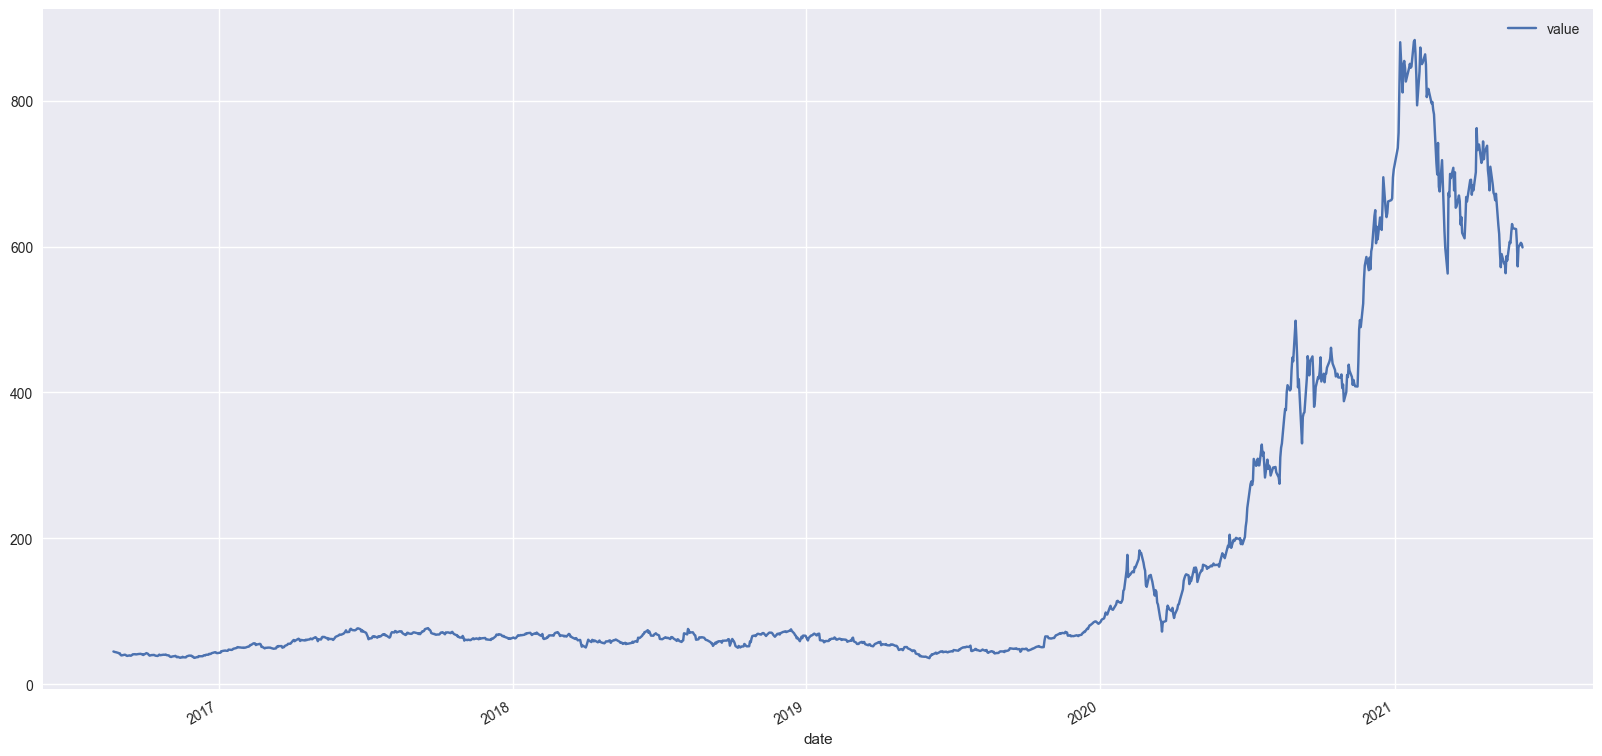

In [19]:
# quick demo: Tesla daily closing price on NYSE 
xdat = pd.read_csv(CFG.data_folder + 'tesla_prices_5y.csv', usecols = ['Date', 'Close'])
xdat.columns = ['date', 'value']

# xdat['value'] = np.log1p(xdat['value'])
xdat['date'] = pd.to_datetime(xdat['date'])
xdat.set_index('date').plot()

TODO

In [20]:
result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.223000
p-value: 0.935724


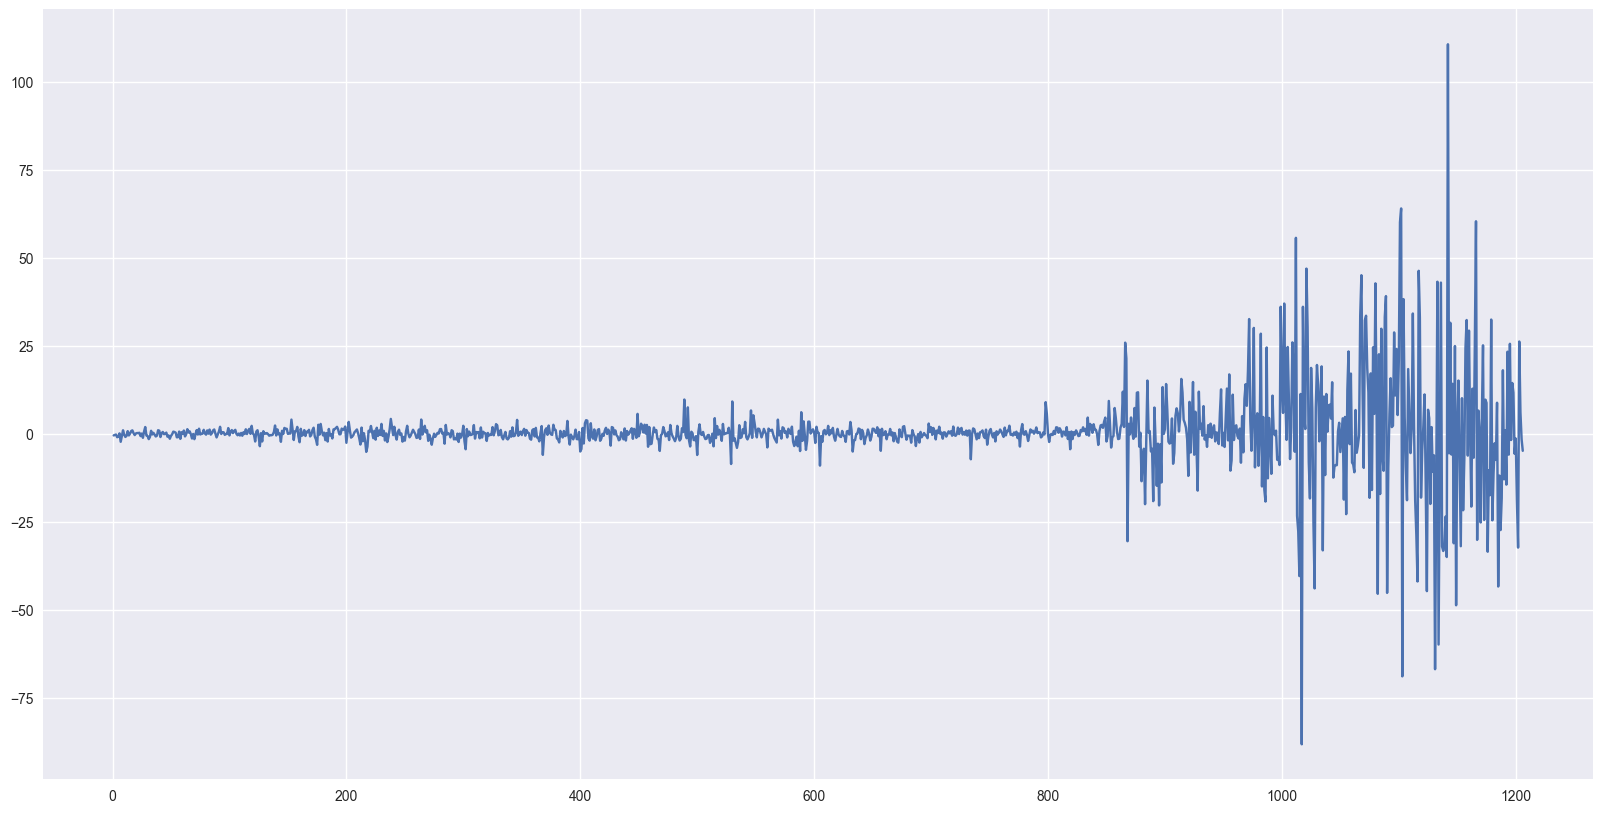

In [21]:
ydat = xdat['value'].diff()
ydat.plot()
print()

TODO

In [22]:
result = adfuller(ydat.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.940299
p-value: 0.000000


## SARIMA


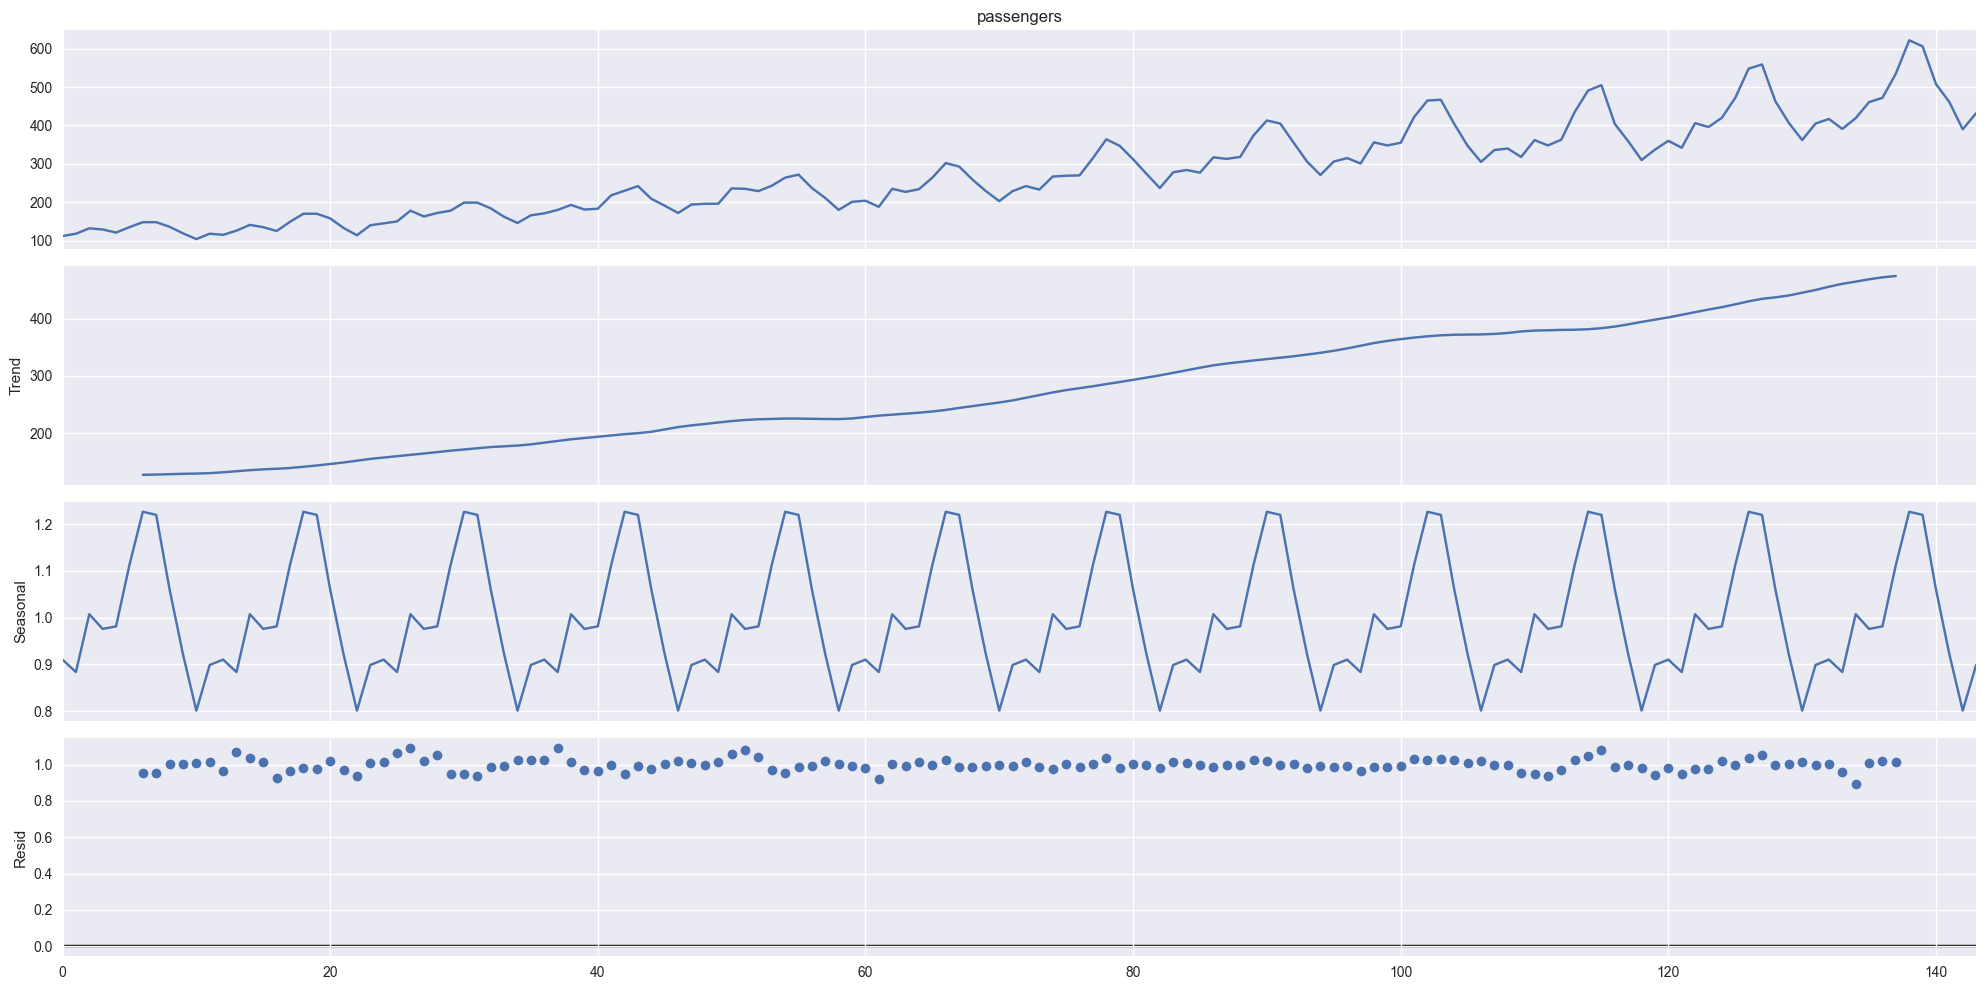

In [23]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])


decomposition = seasonal_decompose(series['passengers'], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [24]:
# check stationarity
result = adfuller(decomposition.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4203766867831889.000000
p-value: 0.000000


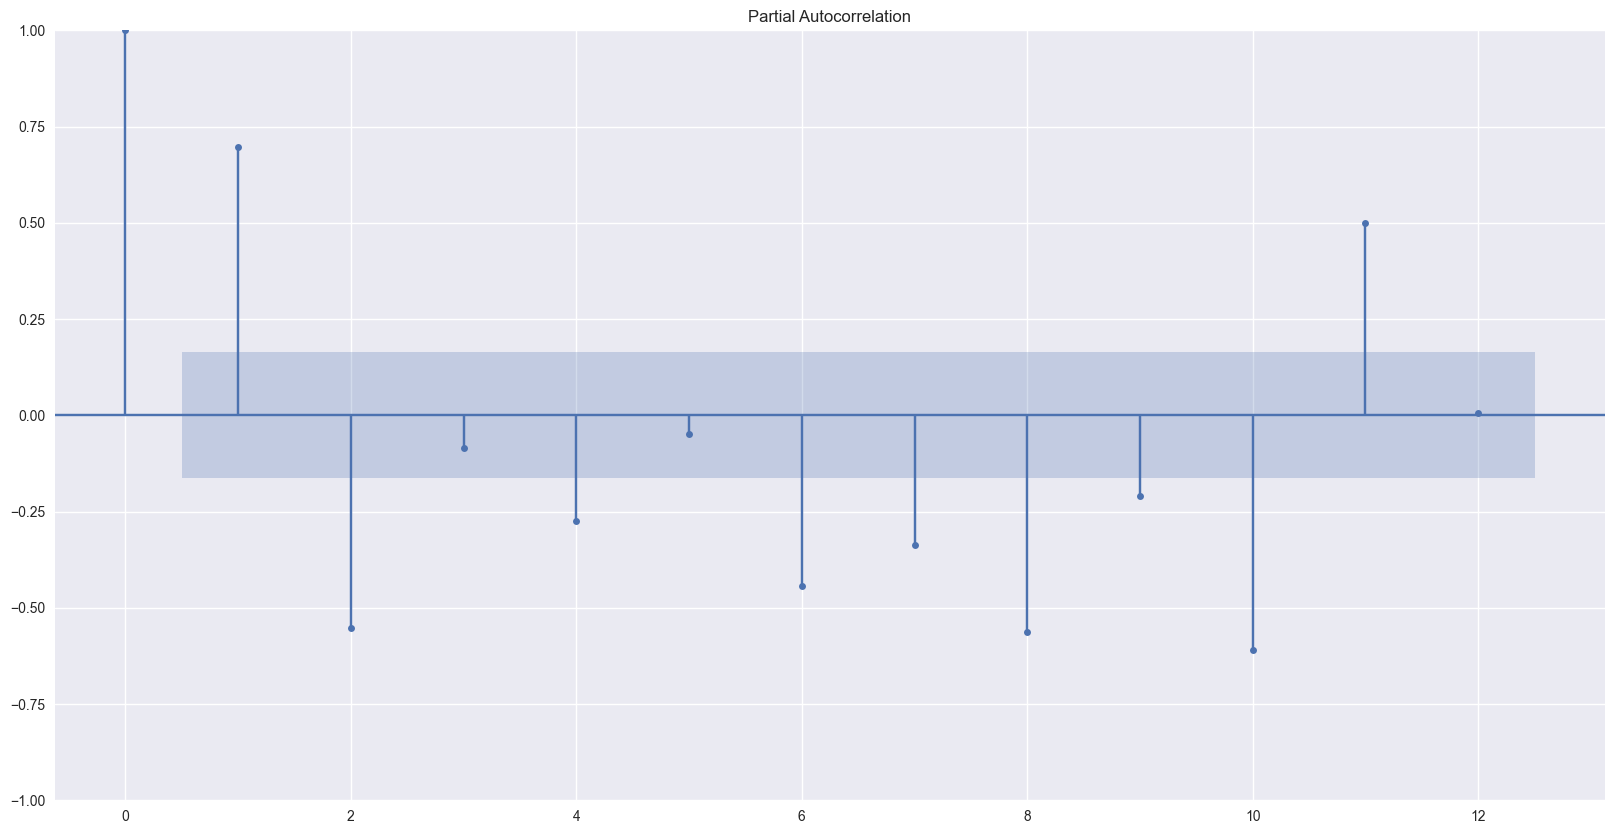

In [25]:
plot_pacf(decomposition.seasonal, lags = 12); print()

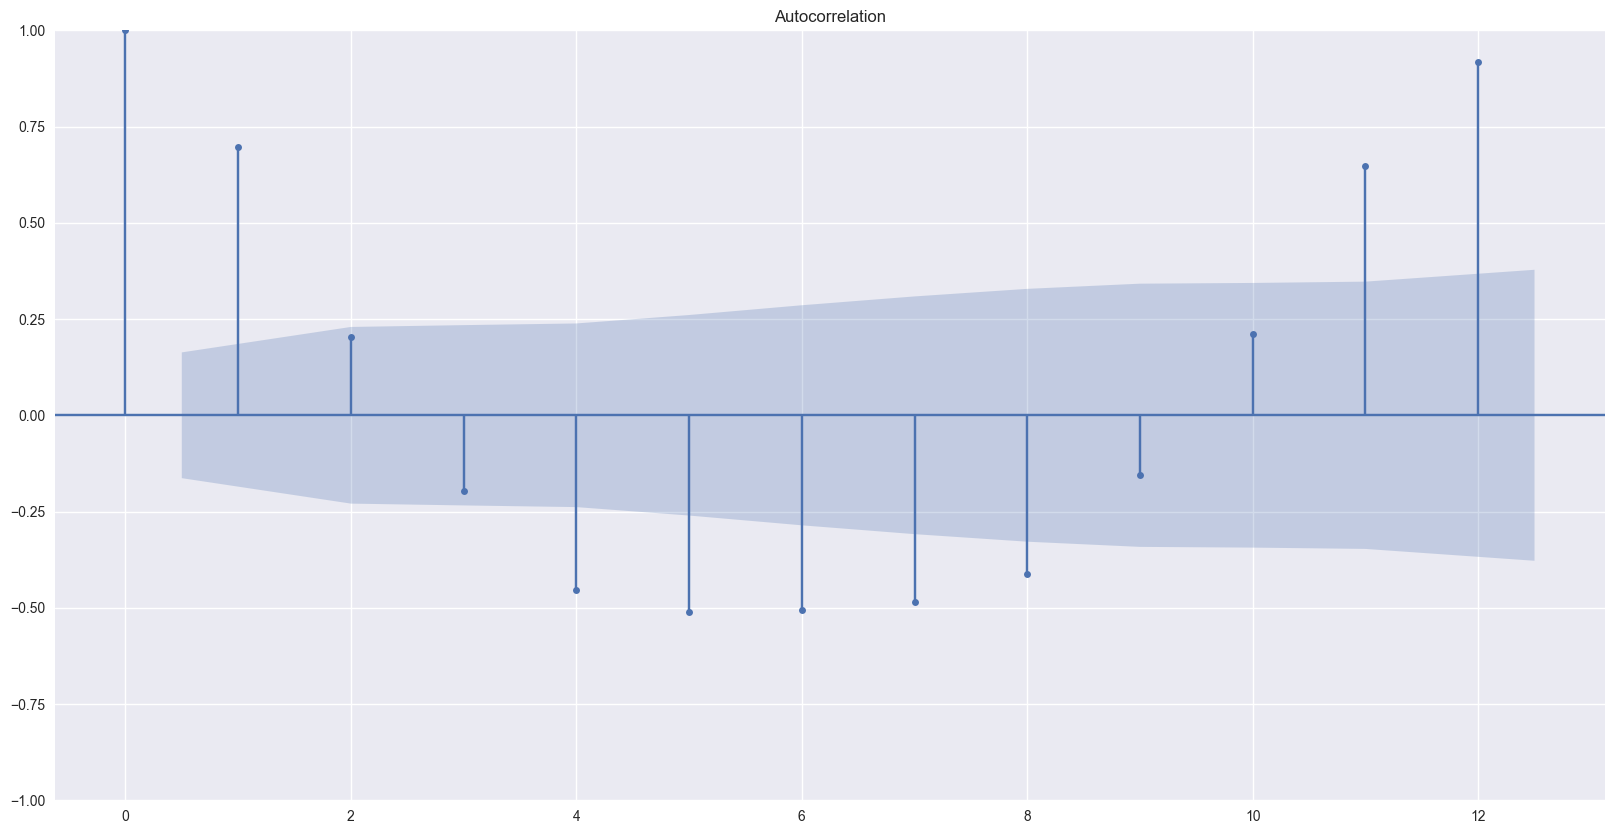

In [26]:
plot_acf(decomposition.seasonal, lags = 12); print()

## SARIMAX

In [27]:
# TODO

TODO

# Building a model

In [28]:
# load the data
train = pd.read_csv(CFG.data_folder + 'train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv(CFG.data_folder + 'test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)

TODO

In [29]:
# we subset to one item x store combination
buf = df[(df.item==1)&(df.store==1)].copy()
buf.head(10)

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1
2013-01-06,NaN,1,12.0,1
2013-01-07,NaN,1,10.0,1
2013-01-08,NaN,1,9.0,1
2013-01-09,NaN,1,12.0,1


TODO

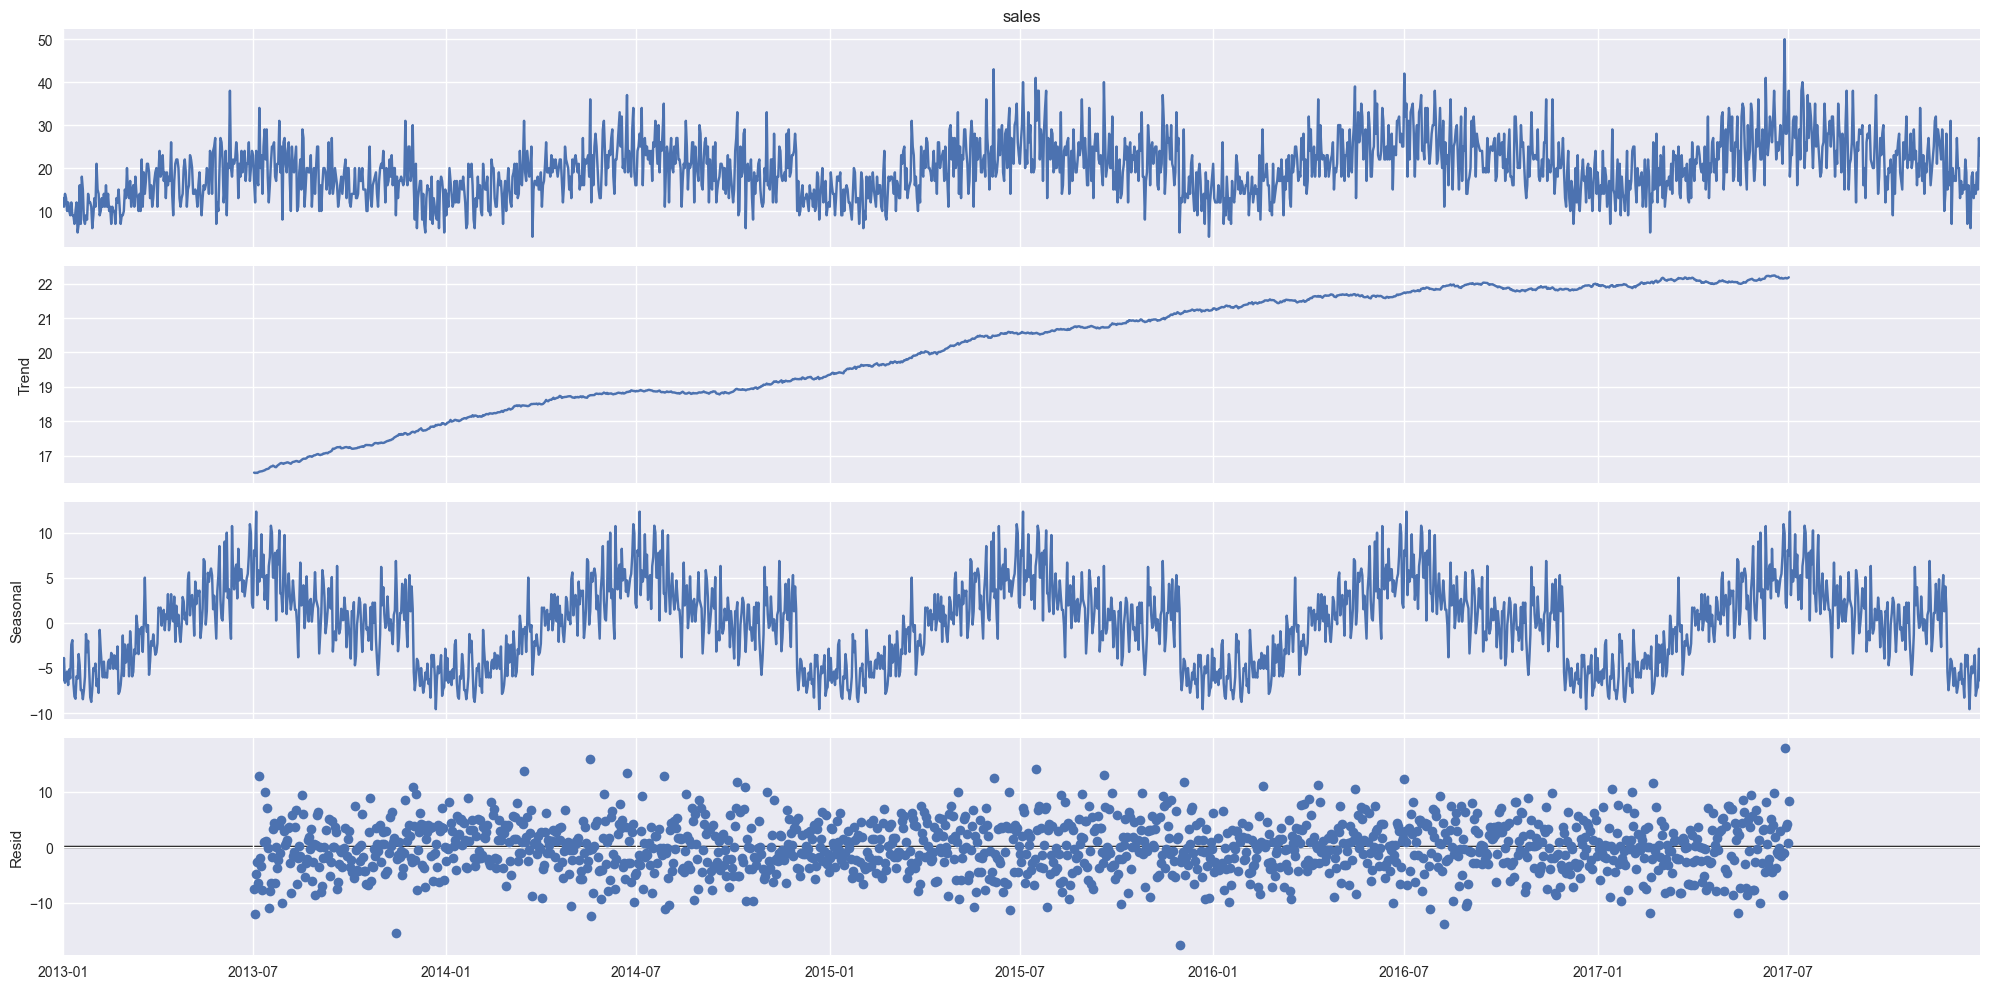

In [30]:
# what do the components look like? 
decomposition = seasonal_decompose(buf.sales.dropna(),period =365)
figure = decomposition.plot()
plt.show()

TODO

In [31]:
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
x0 = buf['sales'][tr_start:tr_end].dropna()
x1 = buf['sales'][te_start:te_end].dropna()

TODO

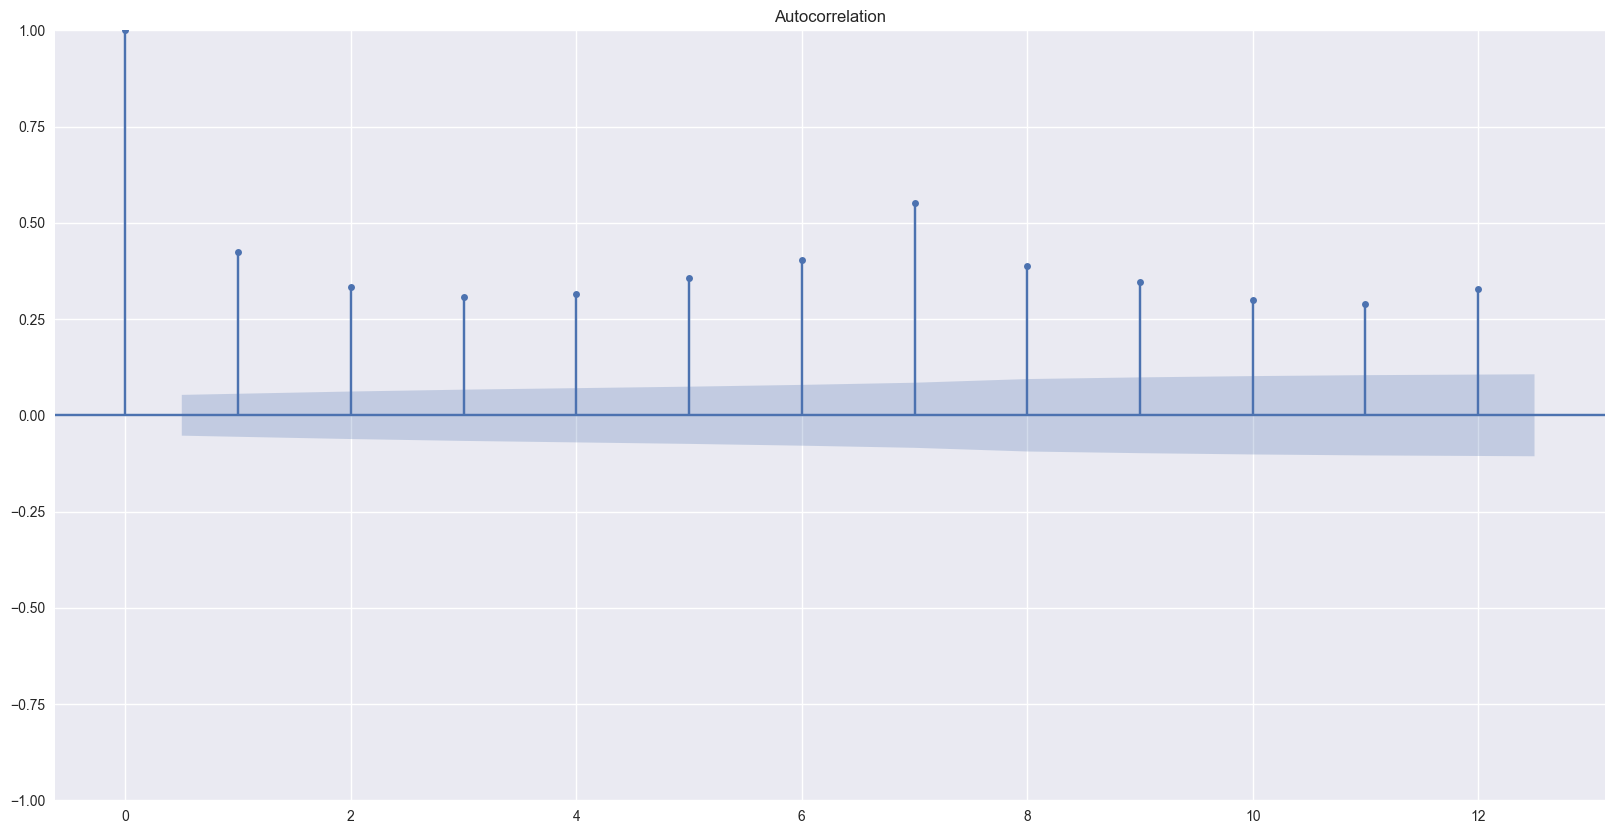

In [32]:
# examine autocorrelation
plot_acf(x0, lags = 12); print()


In [33]:
model_autoARIMA = auto_arima(x0, start_p=7, start_q=7 ,
                      test='adf',       
                      max_p= 7, max_q=7, 
                      m= 7,              
                      d= 1,
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9783.794, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9076.573, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9482.428, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8942.628, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=9292.960, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8771.023, Time=0.20 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8902.831, Time=0.11 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.43 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.00 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=8677.203, Time=0.20 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8810.188, Time=0.13 s

TODO

In [34]:
print(model_autoARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1369
Model:             SARIMAX(6, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -4277.811
Date:                           Sun, 18 Jan 2026   AIC                           8573.621
Time:                                   21:45:16   BIC                           8620.565
Sample:                               01-01-2014   HQIC                          8591.194
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8487      0.028    -30.292      0.000      -0.904      -0.794
ar.L2         -0.7342      0.036    -20.322

TODO

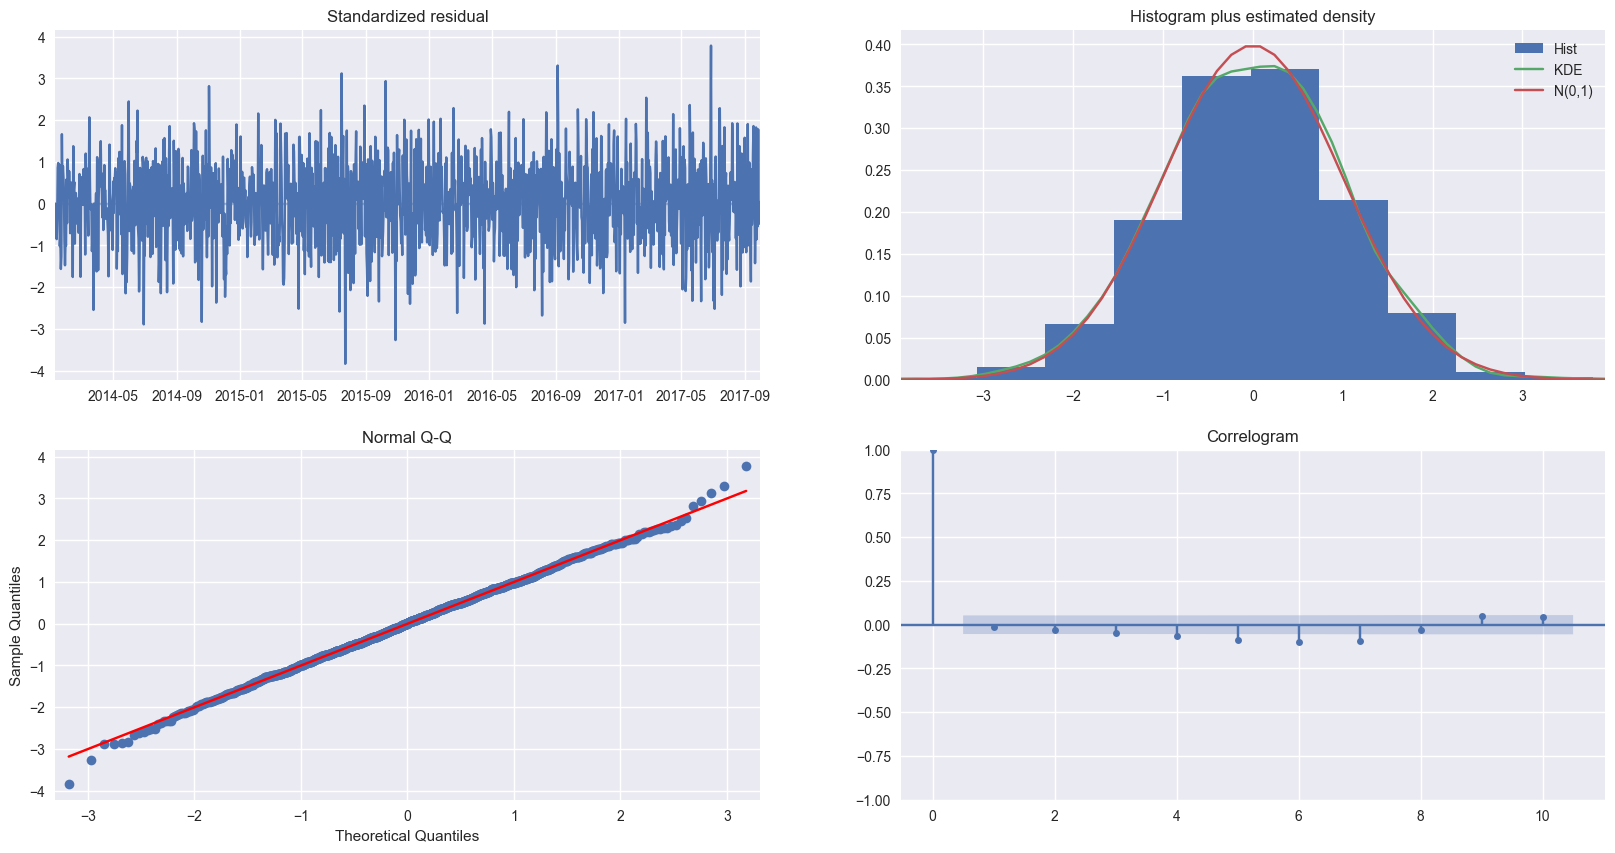

In [35]:
model_autoARIMA.plot_diagnostics()
plt.show()

TODO

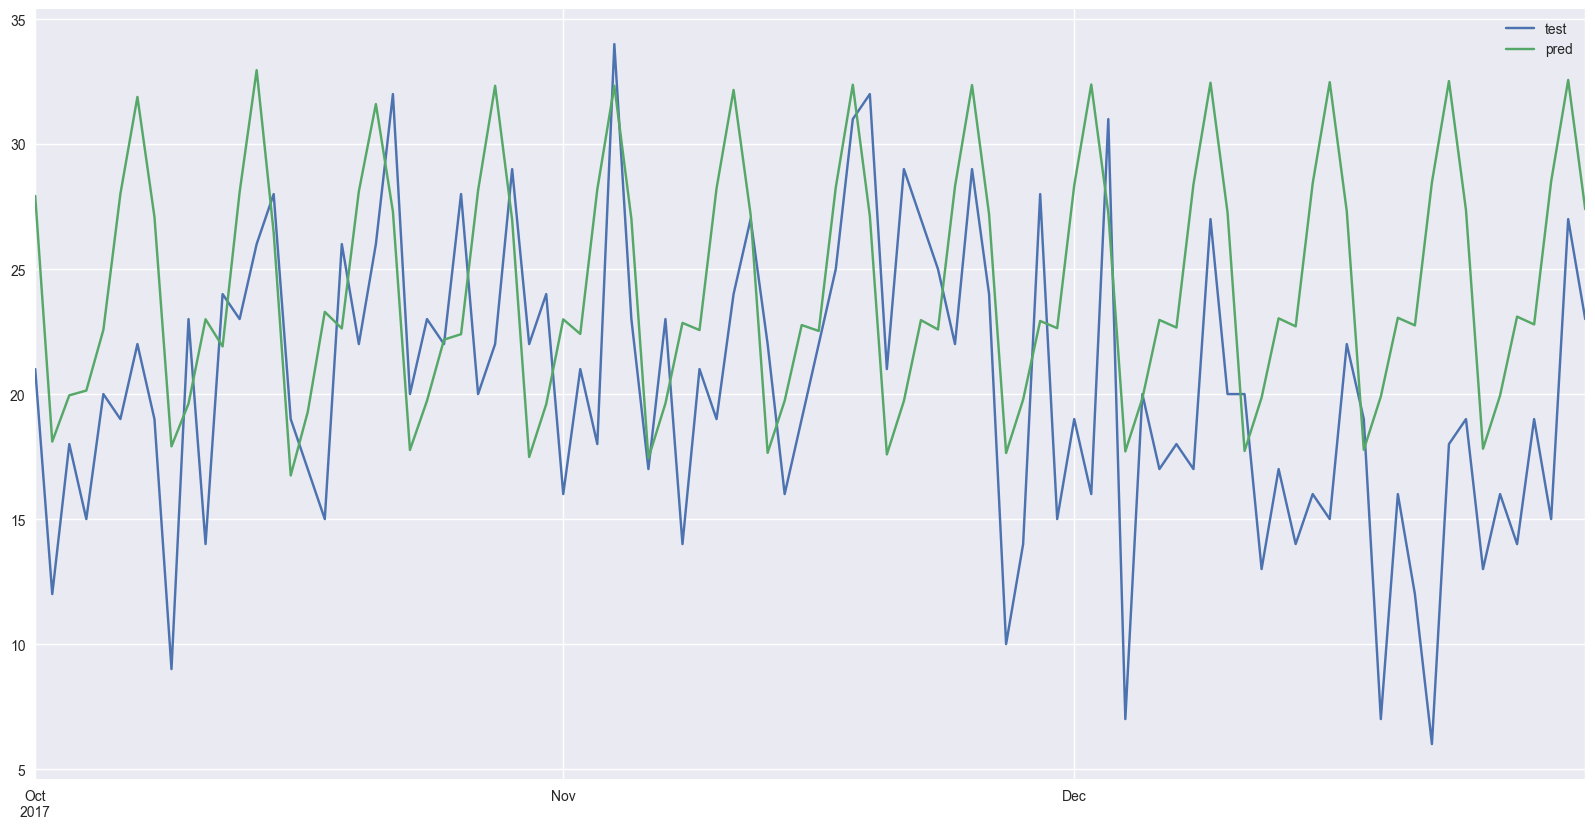

In [36]:
pred = model_autoARIMA.predict(x1.shape[0])

pd.DataFrame({'test':x1,'pred':pred}).plot();plt.show()

TODO